# Quantum RBM training on the OptDigits Dataset for reconstruction and classification
This is an example on quantum annealing training of an RBM on the OptDigits
dataset.
Developed by: Jose Pinilla

In [1]:
# Required packages
import qaml
import torch
torch.manual_seed(0) # For deterministic weights

import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as torch_transforms


In [2]:
################################# Hyperparameters ##############################
M,N = SHAPE = (8,8)
EPOCHS = 75
BATCH_SIZE = 1024
SUBCLASSES = [1,2,3,4]
DATA_SIZE = N*M
LABEL_SIZE = len(SUBCLASSES)
# Stochastic Gradient Descent
learning_rate = 0.1
weight_decay = 1e-4
momentum = 0.5


Using downloaded and verified file ./data/OptDigits\raw\optdigits.tra
Using downloaded and verified file ./data/OptDigits\raw\optdigits.tes


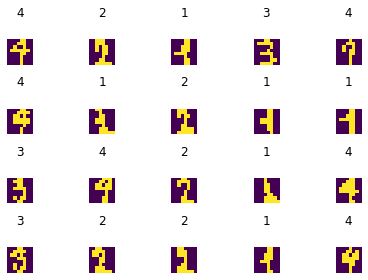

In [3]:
#################################### Input Data ################################
train_dataset = qaml.datasets.OptDigits(root='./data/', train=True,
                                    transform=torch_transforms.Compose([
                                    torch_transforms.ToTensor(),
                                    lambda x:(x>0.5).to(x.dtype)]), #Binarize
                                    target_transform=torch_transforms.Compose([
                                    lambda x:torch.LongTensor([x.astype(int)]),
                                    lambda x:F.one_hot(x-1,len(SUBCLASSES))]),
                                    download=True)

tr_idx = [i for i,y in enumerate(train_dataset.targets) if y in SUBCLASSES]
sampler = torch.utils.data.SubsetRandomSampler(tr_idx)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           sampler=sampler)

fig,axs = plt.subplots(4,5)
subdataset = list(zip(train_dataset.data[tr_idx],train_dataset.targets[tr_idx]))
for ax,(img,label) in zip(axs.flat,subdataset):
    ax.matshow(img>0.5)
    ax.set_title(int(label))
    ax.axis('off')
plt.tight_layout()

test_dataset = qaml.datasets.OptDigits(root='./data/', train=False,
                                    transform=torch_transforms.Compose([
                                    torch_transforms.ToTensor(),
                                    lambda x:(x>0.5).to(x.dtype)]), #Binarize
                                    target_transform=torch_transforms.Compose([
                                    lambda x:torch.LongTensor([x.astype(int)]),
                                    lambda x:F.one_hot(x-1,len(SUBCLASSES))]),
                                    download=True)

test_idx = [i for i,y in enumerate(test_dataset.targets) if y in SUBCLASSES]
sampler = torch.utils.data.SubsetRandomSampler(test_idx)
test_loader = torch.utils.data.DataLoader(test_dataset,sampler=sampler)


In [4]:
################################# Model Definition #############################
VISIBLE_SIZE = DATA_SIZE + LABEL_SIZE
HIDDEN_SIZE = 16

# Specify model with dimensions
rbm = qaml.nn.RBM(VISIBLE_SIZE,HIDDEN_SIZE)

# Initialize biases
_ = torch.nn.init.uniform_(rbm.c,-0.5,0.5)
_ = torch.nn.init.zeros_(rbm.c)
_ = torch.nn.init.uniform_(rbm.W,-0.5,0.5)

# Set up optimizer
beta = 2.5
optimizer = torch.optim.SGD(rbm.parameters(),lr=learning_rate/beta,
                            weight_decay=weight_decay,momentum=momentum)

# Set up training mechanisms
auto_scale = True
solver_name = "Advantage_system4.1"
qa_sampler = qaml.sampler.QASampler(rbm,solver=solver_name,beta=beta)

# Loss and autograd
CD = qaml.autograd.SampleBasedConstrastiveDivergence()


In [5]:
################################## Model Training ##############################
# Set the model to training mode
rbm.train()
err_log = []
scalar_log = []
accuracy_log = []
b_log = [rbm.b.detach().clone().numpy()]
c_log = [rbm.c.detach().clone().numpy()]
W_log = [rbm.W.detach().clone().numpy().flatten()]
for t in range(EPOCHS):
    epoch_error = torch.Tensor([0.])

    for img_batch, labels_batch in train_loader:
        input_data = torch.cat((img_batch.flatten(1),labels_batch.flatten(1)),1)

        # Negative Phase
        vk, prob_hk = qa_sampler(BATCH_SIZE,auto_scale=auto_scale,num_spin_reversal_transforms=4)
        scale = qa_sampler.scalar*qa_sampler.beta if auto_scale else 1.0
        # Positive Phase
        v0,prob_h0 = input_data,rbm(input_data,scale=scale)

        # Reconstruction error from Contrastive Divergence
        err = CD.apply((v0,prob_h0), (vk,prob_hk), *rbm.parameters())

        # Do not accumulate gradients
        optimizer.zero_grad()

        # Compute gradients
        err.backward()

        # Update parameters
        optimizer.step()

        #Accumulate error for this epoch
        epoch_error  += err

    # Error Log
    b_log.append(rbm.b.detach().clone().numpy())
    c_log.append(rbm.c.detach().clone().numpy())
    W_log.append(rbm.W.detach().clone().numpy().flatten())
    err_log.append(epoch_error.item())
    scalar_log.append(qa_sampler.scalar)
    print(f"Epoch {t} Reconstruction Error = {epoch_error.item()}")
    ############################## CLASSIFICATION ##################################
    count = 0
    for i,(test_data, test_label) in enumerate(test_loader):
        recon_data = torch.cat((test_data.flatten(1),torch.zeros(1,LABEL_SIZE)),dim=1)
        recon_hk = rbm(recon_data,scale=scale)
        data_pred,label_pred = rbm.generate(recon_hk,scale=scale).split((DATA_SIZE,LABEL_SIZE),dim=1)
        if label_pred.argmax() == test_label.argmax():
            count+=1
    accuracy_log.append(count/len(test_idx))
    print(f"Testing accuracy: {count}/{len(test_idx)} ({count/len(test_idx):.2f})")


Epoch 0 Reconstruction Error = 57.66032409667969
Testing accuracy: 227/723 (0.31)
Epoch 1 Reconstruction Error = 38.33002853393555
Testing accuracy: 220/723 (0.30)
Epoch 2 Reconstruction Error = 23.01388931274414
Testing accuracy: 178/723 (0.25)
Epoch 3 Reconstruction Error = 15.879783630371094
Testing accuracy: 178/723 (0.25)
Epoch 4 Reconstruction Error = 12.167451858520508
Testing accuracy: 175/723 (0.24)
Epoch 5 Reconstruction Error = 11.102749824523926
Testing accuracy: 175/723 (0.24)
Epoch 6 Reconstruction Error = 8.9912109375
Testing accuracy: 180/723 (0.25)
Epoch 7 Reconstruction Error = 7.957427024841309
Testing accuracy: 184/723 (0.25)
Epoch 8 Reconstruction Error = 7.433199882507324
Testing accuracy: 195/723 (0.27)
Epoch 9 Reconstruction Error = 7.263540744781494
Testing accuracy: 210/723 (0.29)
Epoch 10 Reconstruction Error = 6.411762714385986
Testing accuracy: 326/723 (0.45)
Epoch 11 Reconstruction Error = 6.850801467895508
Testing accuracy: 338/723 (0.47)
Epoch 12 Reconst

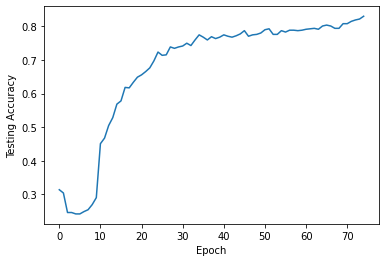

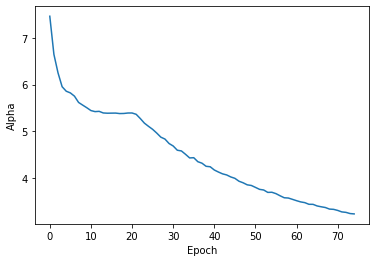

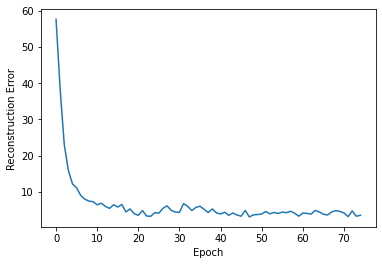

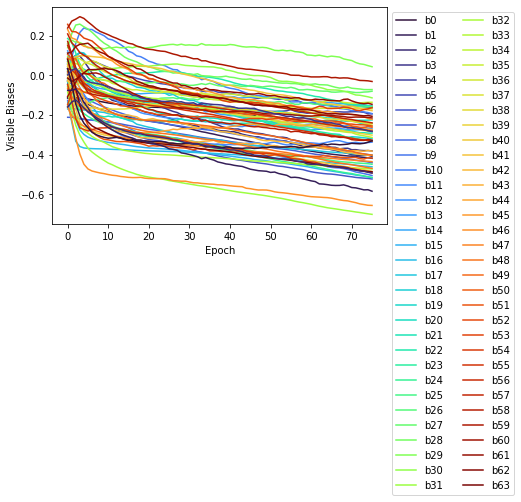

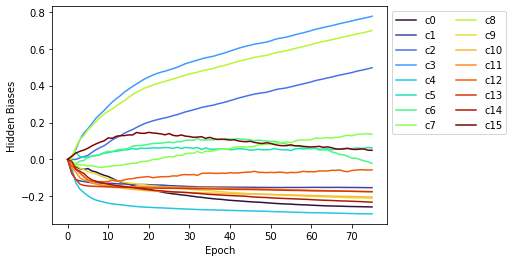

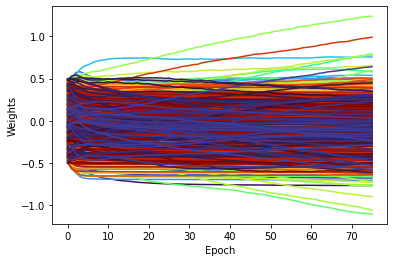

In [6]:
############################ MODEL VISUALIZATION ###############################

# Testing accuracy graph
fig, ax = plt.subplots()
plt.plot(accuracy_log)
plt.ylabel("Testing Accuracy")
plt.xlabel("Epoch")
plt.savefig("quantum_accuracy.pdf")

# Scalar graph
fig, ax = plt.subplots()
plt.plot(scalar_log)
plt.ylabel("Alpha")
plt.xlabel("Epoch")
plt.savefig("alpha.pdf")

# Error graph
fig, ax = plt.subplots()
plt.plot(err_log)
plt.ylabel("Reconstruction Error")
plt.xlabel("Epoch")
plt.savefig("quantum_err.pdf")

# Visible bias graph
fig, ax = plt.subplots()
ax.set_prop_cycle('color', list(plt.get_cmap('turbo',DATA_SIZE).colors))
lc_v = ax.plot(b_log)
plt.legend(iter(lc_v),[f'b{i}' for i in range(DATA_SIZE)],ncol=2,bbox_to_anchor=(1,1))
plt.ylabel("Visible Biases")
plt.xlabel("Epoch")
plt.savefig("quantum_visible_bias_log.pdf")

# Hidden bias graph
fig, ax = plt.subplots()
ax.set_prop_cycle('color', list(plt.get_cmap('turbo',HIDDEN_SIZE).colors))
lc_h = plt.plot(c_log)
plt.legend(lc_h,[f'c{i}' for i in range(HIDDEN_SIZE)],ncol=2,bbox_to_anchor=(1,1))
plt.ylabel("Hidden Biases")
plt.xlabel("Epoch")
plt.savefig("quantum_hidden_bias_log.pdf")

# Weights graph
fig, ax = plt.subplots()
ax.set_prop_cycle('color', list(plt.get_cmap('turbo',HIDDEN_SIZE*DATA_SIZE).colors))
lc_w = plt.plot(W_log)
plt.ylabel("Weights")
plt.xlabel("Epoch")
plt.savefig("quantum_weights_log.pdf")


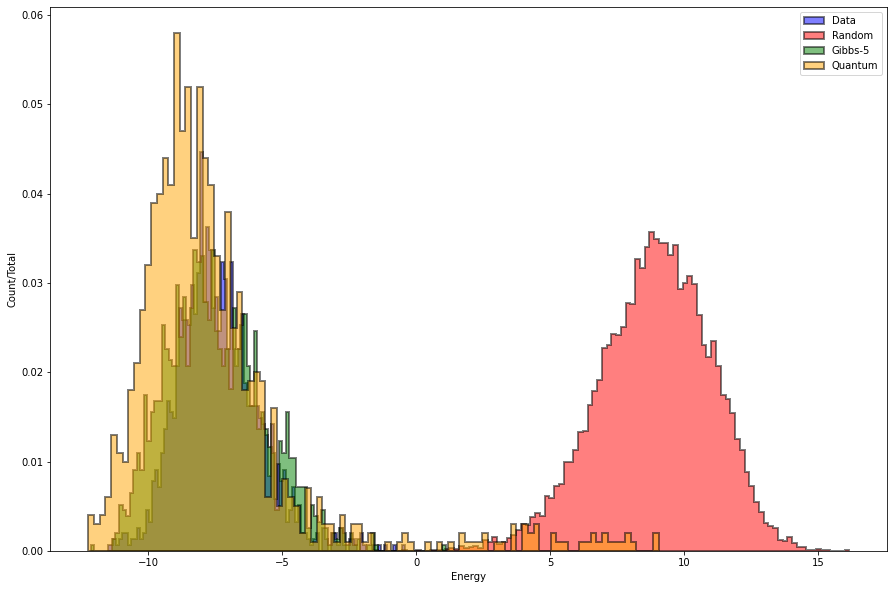

In [7]:
################################## ENERGY ######################################
one_hot = lambda x:F.one_hot(x-1,len(SUBCLASSES)).flatten(0)

data_energies = []
for img,label in subdataset:
    data = torch.cat((torch.tensor(img).flatten(0),one_hot(torch.LongTensor([int(label)]))),0)
    data_energies.append(rbm.free_energy(data).item())

rand_energies = []
rand_data = torch.rand(len(tr_idx)*10,rbm.V)
for img in rand_data:
    rand_energies.append(rbm.free_energy(img.bernoulli()).item())

gibbs_energies = []
gibbs_sampler = qaml.sampler.GibbsNetworkSampler(rbm,beta=beta)
for img,label in subdataset:
    data = torch.cat((torch.tensor(img).flatten(0),one_hot(torch.LongTensor([int(label)]))),0)
    prob_v,prob_h = gibbs_sampler(data,k=5)
    gibbs_energies.append(rbm.free_energy(prob_v.bernoulli()).item())

qa_energies = []
qa_sampleset = qa_sampler(num_reads=1000,auto_scale=True)
for s_v,s_h in zip(*qa_sampleset):
    qa_energies.append(rbm.free_energy(s_v.detach()).item())

plot_data = [(data_energies,  'Data',    'blue'),
             (rand_energies,  'Random',  'red'),
             (gibbs_energies, 'Gibbs-5', 'green'),
             (qa_energies,    'Quantum', 'orange')]

hist_kwargs = {'ec':'k','lw':2.0,'alpha':0.5,'histtype':'stepfilled','bins':100}
weights = lambda data: [1./len(data) for _ in data]

fig, ax = plt.subplots(figsize=(15,10))
for data,name,color in plot_data:
    ax.hist(data,weights=weights(data),label=name,color=color,**hist_kwargs)

plt.xlabel("Energy")
plt.ylabel("Count/Total")
plt.legend(loc='upper right')
plt.savefig("quantum_energies.pdf")



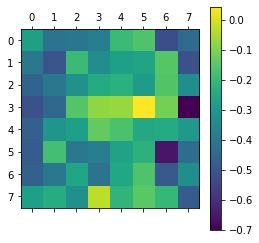

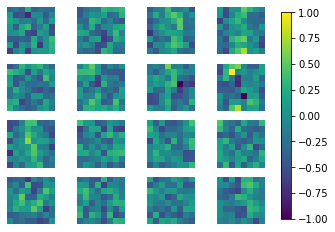

In [8]:
################################## VISUALIZE ###################################
plt.matshow(rbm.b.detach()[:DATA_SIZE].view(*SHAPE), cmap='viridis')
plt.colorbar()

fig,axs = plt.subplots(HIDDEN_SIZE//4,4)
for i,ax in enumerate(axs.flat):
    weight_matrix = rbm.W[i].detach()[:DATA_SIZE].view(*SHAPE)
    ms = ax.matshow(weight_matrix, cmap='viridis', vmin=-1, vmax=1)
    ax.axis('off')
cbar = fig.colorbar(ms, ax=axs.ravel().tolist(), shrink=0.95)
plt.savefig("quantum_weights.pdf")